In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!git clone https://github.com/prajnasb/observations.git

Cloning into 'observations'...
remote: Enumerating objects: 1638, done.
remote: Total 1638 (delta 0), reused 0 (delta 0), pack-reused 1638
Receiving objects: 100% (1638/1638), 75.94 MiB | 13.96 MiB/s, done.
Resolving deltas: 100% (19/19), done.


In [2]:
!git clone https://github.com/kairess/mask-detection.git

Cloning into 'mask-detection'...
remote: Enumerating objects: 33, done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 33
Unpacking objects: 100% (33/33), done.


In [3]:
# tensorflow 2버전
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

plt.style.use('dark_background')

#Load Models

https://deep-learning-study.tistory.com/299

In [4]:
# facenet : 네트워크 불러오기 
# caffemodel 파일 : 얼굴 인식을 위해 ResNet 기본 네트워크를 사용하는 SSD(Single Shot Detector) 프레임워크를 통해 사전 훈련된 모델 가중치 사용
# prototxt 파일 : 모델의 레이어 구성 및 속성 정의
facenet = cv2.dnn.readNet('/content/mask-detection/models/deploy.prototxt', '/content/mask-detection/models/res10_300x300_ssd_iter_140000.caffemodel')

# 마스크 탐지 모델불러오기
model = load_model('/content/mask-detection/models/mask_detector.model')

# Load Image

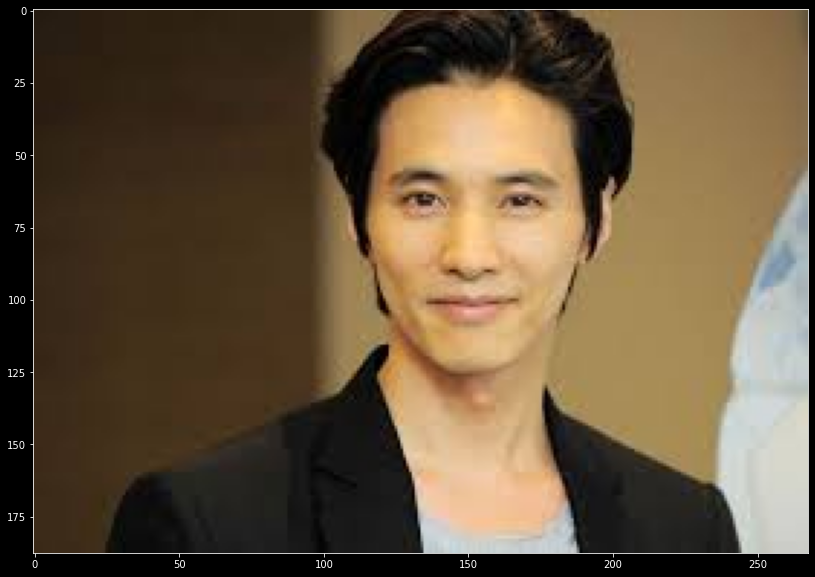

In [6]:
# opencv imread이용해서 test이미지 불러옴
img = cv2.imread('1.jpg')
# 이미지의 shape 지정
h, w = img.shape[:2]

# 시각화
plt.figure(figsize=(16, 10))
# opencv -> BGR 로 읽히는걸 RGB로 바꿈
plt.imshow(img[:, :, ::-1])

# Preprocess Image for Face Detection
마스크가 있는지 없는지 다시 판단

- blob: 동일한 방식으로 전처리된 opencv에서 Mat타입의 4차원(4D Tensor: NCHW) 행렬 [N: 영상 개수, C: 채널 개수,H: 영상 세로,W: 영상 가로이미지]
- scalefactor : 선택적으로 특정 요소만큼 이미지 크기를 늘리거나 줄일 수 있음
- mean : 입력 영상 각 채널에서 뺄 평균값

blobFromImage : 이미지에서 4차원 blob를 만들고 선택적으로 크기를 조정할 수 있음

In [7]:
#이미지 blob로 설정

blob = cv2.dnn.blobFromImage(img, scalefactor=1., size=(300, 300), mean=(104., 177., 123.))

# setInput: Net에 blob 형태의 데이터 넣어주는 함수
facenet.setInput(blob)

# forward : 결과 예측 생성 가능
dets = facenet.forward()

#Detect Faces

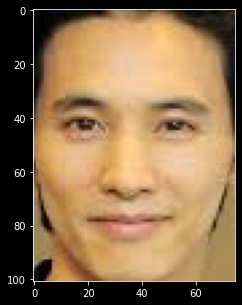

In [8]:
faces = []

# 여러 얼굴 탐지 0.5미만은 continue
for i in range(dets.shape[2]):
    confidence = dets[0, 0, i, 2]
    if confidence < 0.5:
        continue

    # x,y 바운딩박스 처리 
    x1 = int(dets[0, 0, i, 3] * w)
    y1 = int(dets[0, 0, i, 4] * h)
    x2 = int(dets[0, 0, i, 5] * w)
    y2 = int(dets[0, 0, i, 6] * h)

    #[y:y+h,x:x+w]
    
    # 원본이미지에서 얼굴만 잘라내고 저장
    face = img[y1:y2, x1:x2]
    faces.append(face)

plt.figure(figsize=(16, 5))

# 잘 저장이 되었는지 확인
for i, face in enumerate(faces):
    plt.subplot(1, len(faces), i+1)
    plt.imshow(face[:, :, ::-1])

In [10]:
cv2.imwrite('/content/crop1.jpg',face)

True

#Detect Masks from Faces

In [ ]:
# 마스크 썼는지 확인

plt.figure(figsize=(16, 5))

# 얼굴의 갯수만큼 루프 돌아 예측
for i, face in enumerate(faces):
    # 전처리
    face_input = cv2.resize(face, dsize=(224, 224)) # 크기 변경
    face_input = cv2.cvtColor(face_input, cv2.COLOR_BGR2RGB) # 컬러시스템 변경 COLOR_BGR2RGB : RGB로변경
    face_input = preprocess_input(face_input) # preprocess 똑같이 해주기 위해 INPUT과정 
    face_input = np.expand_dims(face_input, axis=0) # 차원 추가 (224,224,3) -> (1,224,224,3)
    
    # 미리 Load 해둔 모델에 예측 (마스크쓴확률, 아닌 확률)
    # squeeze 
    mask, nomask = model.predict(face_input).squeeze()

    # 확률 시각화
    plt.subplot(1, len(faces), i+1)
    plt.imshow(face[:, :, ::-1])
    plt.title('%.2f%%' % (mask * 100))

<Figure size 1152x360 with 0 Axes>